<a href="https://colab.research.google.com/github/Andreas-Lukito/twitter-airline-sentiment-analysis/blob/dev%2Fandreas/colab_notebooks/02distillbert-fine-tune-imbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distillbert Fine-Tune Model (Imbalanced_Data)

We will fine tune:
- Learning Rate to `5e-5`
- Optimizer to Adam
- max_length to `256`
- batch size to `16`

## Iport Libraries

In [1]:
# Common Python Libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import Adam

# Data Preprocessing
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from sklearn.preprocessing import OrdinalEncoder

# Model Metrics
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/airline_sentiment_analysis"
SEED = 42

model_name = "distilbert-base-uncased"

Mounted at /content/drive


## Choose Device

In [2]:
# Detect available device
if torch.cuda.is_available():
    # check if ROCm backend is active
    if torch.version.hip is not None:
        backend = "ROCm"
    else:
        backend = "CUDA"

    device = torch.device("cuda")
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Backend: {backend}")
else:
    device = torch.device("cpu")
    print("PyTorch is not using GPU — running on CPU")

PyTorch is using GPU: NVIDIA L4
Backend: CUDA


## Import Data

In [3]:
tweets_data_path = os.path.join(project_path, "data/cleaned_data.csv")
tweets_data = pd.read_csv(tweets_data_path, sep = ",")

In [4]:
tweets_data.head()

,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,length,clean_text
0,0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),4,What said.
1,1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),9,plus you've added commercials to the experienc...
2,2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),12,I didn't today... Must mean I need to take ano...
3,3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),17,"it's really aggressive to blast obnoxious ""ent..."
4,4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),10,and it's a really big bad thing about it


## Split the data to Train, Test, and Validation

In [5]:
test_size = 0.20
val_size = 0.10

# Splitting the data into train and temp (which will be further split into validation and test)
train_df, test_df = train_test_split(tweets_data, test_size=test_size, random_state=SEED)

# Splitting train into validation and test sets
train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=SEED)

In [6]:
# Split to x and y values
x_train = train_df["clean_text"].tolist()
y_train = train_df[["airline_sentiment"]]

x_test = test_df["clean_text"].tolist()
y_test = test_df[["airline_sentiment"]]

x_val = val_df["clean_text"].tolist()
y_val = val_df[["airline_sentiment"]]


## Data Preprocessing

### Encoding the Y Values

In [7]:
y_ord_enc = OrdinalEncoder(categories=[["negative", "neutral", "positive"]])

y_train = y_ord_enc.fit_transform(y_train).flatten()
y_test = y_ord_enc.transform(y_test).flatten()
y_val = y_ord_enc.transform(y_val).flatten()

### Tokenizer for the text

In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

class sentiment_text(torch.utils.data.Dataset): # create a class that behaves like torch.utils.data.Dataset
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer( # converts raw text -> model input
                                    texts,
                                    truncation = True,
                                    padding = True,
                                    max_length = 256 # since the max length of the tweets are around 35 - 40 words
                                )

        # get the labels
        self.labels = labels

    def __getitem__(self, index): # so that pytorch can get the data (returns one sample of the data)
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()} # self.encoding stores (input_ids, attention_mask, label)
        item["labels"] = torch.tensor(self.labels[index], dtype=torch.long) # get the label on the chosen index while converting to a torch tensor format
        return item

    def __len__(self): #to get the length of the data (used when batching)
        return len(self.labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
train_dataset = sentiment_text(x_train, y_train, tokenizer)
test_dataset  = sentiment_text(x_test, y_test, tokenizer)
val_dataset  = sentiment_text(x_val, y_val, tokenizer)

### Data Loader for the Model

In [10]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)
val_loader  = DataLoader(val_dataset, batch_size=32)

## Train Baseline Model

In [11]:
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3 # sinc there is positive, negative, Neutral
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
optimizer = Adam(model.parameters(), lr=5e-5)

In [13]:
model.to(device)
model.train() #make the model to training mode

for epoch in tqdm(range(3), desc="Training Distillbert Model", unit="epoch"):  # number of epochs

    for batch in train_loader:
        for k, v in batch.items():
            batch[k] = v.to(device)

        optimizer.zero_grad() # Resets all gradients to zero before computing new ones.
        outputs = model(**batch)  # forward pass
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} loss: {loss.item()}")

Training Distillbert Model:  33%|███▎      | 1/3 [00:23<00:47, 23.65s/epoch]

Epoch 1 loss: 0.4573170244693756


Training Distillbert Model:  67%|██████▋   | 2/3 [00:46<00:23, 23.28s/epoch]

Epoch 2 loss: 0.15300525724887848


Training Distillbert Model: 100%|██████████| 3/3 [01:09<00:00, 23.30s/epoch]

Epoch 3 loss: 0.07639021426439285


## Model Evaluation

In [14]:
model.eval()  # set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # no gradients needed
    for batch in test_loader:
        # move data to device (CPU or GPU)
        for k, v in batch.items():
            batch[k] = v.to(device)

        outputs = model(**batch)
        logits = outputs.logits  # raw predictions

        preds = torch.argmax(logits, dim=1)  # pick class with highest score

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

In [15]:
labels = np.array(all_labels)
preds = np.array(all_preds)

In [16]:
print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"], zero_division=0))

              precision    recall  f1-score   support

    negative       0.86      0.94      0.90      1880
     neutral       0.71      0.56      0.63       582
    positive       0.80      0.71      0.76       459

    accuracy                           0.83      2921
   macro avg       0.79      0.74      0.76      2921
weighted avg       0.82      0.83      0.82      2921



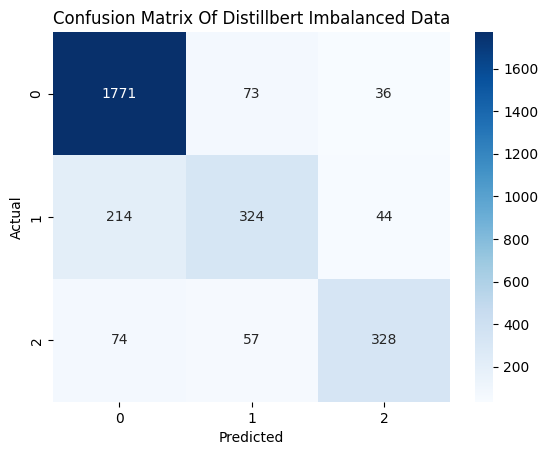

In [17]:
cm = confusion_matrix(labels, preds)

sns.heatmap(
    cm,
    cmap= "Blues",
    annot= True,
    fmt= "g"
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of Distillbert Imbalanced Data")

plt.show()